In [1]:
!pip install --quiet /kaggle/input/kerasapplications
!pip install --quiet /kaggle/input/efficientnet-keras-source-code

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import math, os, random, re
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
from tensorflow import keras
import efficientnet.tfkeras as efn
from functools import partial
from sklearn.model_selection import train_test_split

In [3]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)
strategy.num_replicas_in_sync

8

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path('cassava-leaf-disease-tfrecords-512x512')
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [512, 512]
CLASSES = ['0', '1', '2', '3', '4']
EPOCHS = 25
SEED = 42

In [5]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0     ###
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

In [6]:
TRAIN_FILENAMES = tf.io.gfile.glob(GCS_PATH + "/Id_train*.tfrec")
#TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test_tfrecords/ld_test*.tfrec')

#TRAIN_FILENAMES, VALID_FILENAMES = train_test_split(TRAIN_FILENAMES, test_size = 0.3, random_state = SEED)

In [7]:
rng = tf.random.Generator.from_seed(SEED, alg='philox')

def data_augment(image, label):
    seed = rng.make_seeds(2)[0]
    image = tf.image.stateless_random_flip_left_right(image, seed=seed)
    image = tf.image.stateless_random_flip_up_down(image, seed=seed)
    image = tf.image.stateless_random_brightness(image, 0.3, seed=seed)
    return image, label

def get_training_dataset():
    dataset = load_dataset(TRAIN_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048, seed = SEED)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(VALID_FILENAMES, labeled=True) 
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TRAIN_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.map(lambda x,y: x, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [8]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAIN_FILENAMES)
#NUM_VALID_IMAGES = count_data_items(VALID_FILENAMES)

STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
#VALID_STEPS = NUM_VALID_IMAGES // BATCH_SIZE

In [9]:
#lr_scheduler1 = keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=1e-3, 
#    decay_steps=10000, 
#    decay_rate=0.9)

lr1 = tf.keras.experimental.CosineDecay(initial_learning_rate=1e-4, decay_steps=30000)

with strategy.scope():       
    input_layer = tf.keras.layers.Input(shape=[*IMAGE_SIZE,3], name='input_image')
    
    base_model = efn.EfficientNetB4(weights='noisy-student', include_top=False, pooling='avg')
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        input_layer,
        base_model,
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr1),           #epsilon=0.001
        loss='sparse_categorical_crossentropy',  
        metrics=['sparse_categorical_accuracy'])

model.summary()

71680000/71678424 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Functional) (None, 1792)              17673816  
_________________________________________________________________
dropout (Dropout)            (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 8965      
Total params: 17,682,781
Trainable params: 8,965
Non-trainable params: 17,673,816
_________________________________________________________________


In [10]:
train_dataset = get_training_dataset()
#valid_dataset = get_validation_dataset()

In [11]:
early_stop1 = tf.keras.callbacks.EarlyStopping(monitor = 'loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

In [12]:
history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=EPOCHS,
                    #validation_data=valid_dataset,
                    #validation_steps=VALID_STEPS,
                    callbacks = [early_stop1])

Epoch 1/25
167/167 [==============================] - 65s 201ms/step - loss: 1.2840 - sparse_categorical_accuracy: 0.5604
Epoch 2/25
167/167 [==============================] - 34s 204ms/step - loss: 1.0111 - sparse_categorical_accuracy: 0.6200
Epoch 3/25
167/167 [==============================] - 33s 198ms/step - loss: 0.9297 - sparse_categorical_accuracy: 0.6373
Epoch 4/25
167/167 [==============================] - 35s 208ms/step - loss: 0.8729 - sparse_categorical_accuracy: 0.6601
Epoch 5/25
167/167 [==============================] - 34s 202ms/step - loss: 0.8367 - sparse_categorical_accuracy: 0.6785
Epoch 6/25
167/167 [==============================] - 35s 209ms/step - loss: 0.8219 - sparse_categorical_accuracy: 0.6873
Epoch 7/25
167/167 [==============================] - 35s 211ms/step - loss: 0.7957 - sparse_categorical_accuracy: 0.7008
Epoch 8/25
167/167 [==============================] - 35s 211ms/step - loss: 0.7876 - sparse_categorical_accuracy: 0.7043
Epoch 9/25
167/167 [====

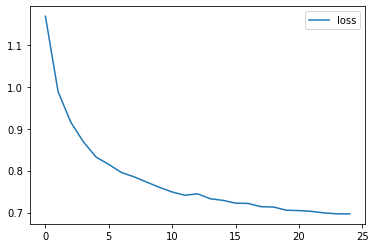

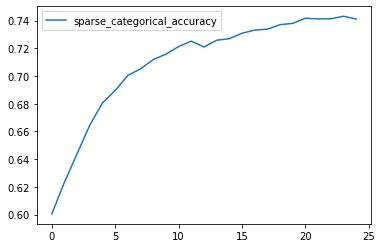

In [13]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss']].plot()                      #, 'val_loss'
history_frame.loc[:, ['sparse_categorical_accuracy']].plot();         #,  'val_sparse_categorical_accuracy'

In [14]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  468


In [15]:
fine_tune_at = 350

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [16]:
for layer in base_model.layers[fine_tune_at:]:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable =  False

In [17]:
#lr_scheduler2 = keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=1e-5, 
#    decay_steps=10000, 
#    decay_rate=0.9)

lr2 = tf.keras.experimental.CosineDecay(initial_learning_rate=1e-5, decay_steps=18000)

early_stop2 = tf.keras.callbacks.EarlyStopping(monitor = 'loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

with strategy.scope():
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr2),
        loss='sparse_categorical_crossentropy',  
        metrics=['sparse_categorical_accuracy'])
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Functional) (None, 1792)              17673816  
_________________________________________________________________
dropout (Dropout)            (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 8965      
Total params: 17,682,781
Trainable params: 11,691,569
Non-trainable params: 5,991,212
_________________________________________________________________


In [18]:
EPOCHS = 55

history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=EPOCHS,
                    #validation_data=valid_dataset,
                    #validation_steps=VALID_STEPS,
                    initial_epoch=history.epoch[-1],
                    callbacks = [early_stop2])

Epoch 25/55
167/167 [==============================] - 74s 220ms/step - loss: 0.6722 - sparse_categorical_accuracy: 0.7521
Epoch 26/55
167/167 [==============================] - 37s 219ms/step - loss: 0.6051 - sparse_categorical_accuracy: 0.7758
Epoch 27/55
167/167 [==============================] - 38s 226ms/step - loss: 0.5690 - sparse_categorical_accuracy: 0.7956
Epoch 28/55
167/167 [==============================] - 38s 226ms/step - loss: 0.5411 - sparse_categorical_accuracy: 0.8069
Epoch 29/55
167/167 [==============================] - 37s 222ms/step - loss: 0.5189 - sparse_categorical_accuracy: 0.8138
Epoch 30/55
167/167 [==============================] - 37s 221ms/step - loss: 0.5029 - sparse_categorical_accuracy: 0.8198
Epoch 31/55
167/167 [==============================] - 38s 225ms/step - loss: 0.4819 - sparse_categorical_accuracy: 0.8321
Epoch 32/55
167/167 [==============================] - 38s 228ms/step - loss: 0.4673 - sparse_categorical_accuracy: 0.8327
Epoch 33/55
167/

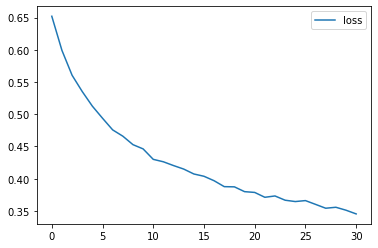

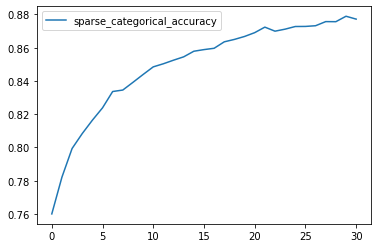

In [19]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss']].plot()          #, 'val_loss'
history_frame.loc[:, ['sparse_categorical_accuracy']].plot();    #, 'val_sparse_categorical_accuracy'

In [20]:
test_ds = get_test_dataset()
test_ds.unbatch().batch(20)
classes = np.argmax(model.predict(test_ds), axis=-1)
u,c = np.unique(classes, return_counts = True)
dict(zip(u,c))

{0: 1061, 1: 2174, 2: 2119, 3: 13408, 4: 2633}

In [21]:
model.save_weights("f42_weights.h5")

In [22]:
model.save("f42_model.h5")